# Exploring Mental Health Data
**Objective:** Predict whether an individual suffers from depression based on a set of responses from a mental health survey.

**Problem task:** Binary classification on the target variable depression (0 = false, 1 = true)

**Dataset source:** Kaggle - Playground Series S4E11


In [90]:
#Marta path:
#Ricardo path:
#Sara path: "/Users/saracortez/feup/3o ano/iart/exploring_mental_health_data/data/train.csv"
import pandas as pd
train_data = pd.read_csv("/Users/saracortez/feup/3o ano/iart/exploring_mental_health_data/data/train.csv")
test_data = pd.read_csv("/Users/saracortez/feup/3o ano/iart/exploring_mental_health_data/data/test.csv")

print(train_data.head())
train_data.describe()

   id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours     

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [91]:
#duplicate removal
bf = len(train_data)
print(f"Number of rows before removing duplicates: {len(train_data)}")
train_data = train_data.drop_duplicates()
af = len(train_data)
print(f"Number of rows after removing duplicates: {len(train_data)}")
if (bf-af) == 0:
    print("(No dup data found)")

Number of rows before removing duplicates: 140700
Number of rows after removing duplicates: 140700
(No dup data found)


In [92]:
#missing value check
def missing_value_info(df):
    total = df.isnull().sum()
    percent = (total / len(df)) * 100
    return pd.DataFrame({'Missing Values': total, 'Percent Missing': percent}).sort_values(by='Percent Missing', ascending=False)
missing_info_with_0 = missing_value_info(train_data)
missing_info = missing_info_with_0[missing_info_with_0['Percent Missing'] > 0.0]
print(missing_info)
print(missing_info_with_0)


                    Missing Values  Percent Missing
Study Satisfaction          112803        80.172708
Academic Pressure           112803        80.172708
CGPA                        112802        80.171997
Profession                   36630        26.034115
Work Pressure                27918        19.842217
Job Satisfaction             27910        19.836532
Dietary Habits                   4         0.002843
Financial Stress                 4         0.002843
Degree                           2         0.001421
                                       Missing Values  Percent Missing
Study Satisfaction                             112803        80.172708
Academic Pressure                              112803        80.172708
CGPA                                           112802        80.171997
Profession                                      36630        26.034115
Work Pressure                                   27918        19.842217
Job Satisfaction                                27910 

since these columns were spotted for missing values, we want to understand their appearance: how many are missing (NaN count in value_counts), if there unexpected 0s or negative values.

### Data prepp

In [93]:
#train_data['Study Satisfaction'].value_counts(dropna=False)
#train_data['Academic Pressure'].value_counts(dropna=False)
#train_data['CGPA'].value_counts(dropna=False)
#train_data['Profession'].value_counts(dropna=False)
#train_data['Work Pressure'].value_counts(dropna=False)
#train_data['Job Satisfaction'].value_counts(dropna=False)
#train_data['Dietary Habits'].value_counts(dropna=False)
#train_data['Financial Stress'].value_counts(dropna=False)
pd.set_option('display.max_rows', None)
train_data['Degree'].value_counts(dropna=False)
#regulated
#Comclusion: all our missing vals are NANS


Degree
Class 12                14729
B.Ed                    11691
B.Arch                   8742
B.Com                    8113
B.Pharm                  5856
BCA                      5739
M.Ed                     5668
MCA                      5234
BBA                      5030
BSc                      5027
MSc                      4879
LLM                      4647
M.Pharm                  4537
M.Tech                   4475
B.Tech                   4425
LLB                      4348
BHM                      4305
MBA                      3818
BA                       3750
ME                       3632
MD                       3383
MHM                      3286
BE                       3104
PhD                      3103
M.Com                    3094
MBBS                     3082
MA                       2887
M.Arch                      5
UX/UI Designer              4
B.Sc                        3
Kalyan                      3
M                           3
LLBA                        2
NaN

In [94]:
# Forçar a visualização completa das contagens
pd.set_option('display.max_rows', None)  # Isso vai permitir que todos os valores sejam exibidos
print(train_data['Profession'].value_counts(dropna=False))


Profession
NaN                       36630
Teacher                   24906
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           1372
Accountant                 13

In [95]:
train_data['Profession'].value_counts(dropna=False)

valid_professions = [
    "Teacher", "Content Writer", "Architect", "Consultant", "HR Manager",
    "Pharmacist", "Doctor", "Business Analyst", "Entrepreneur", "Chemist",
    "Chef", "Educational Consultant", "Data Scientist", "Researcher", "Lawyer",
    "Customer Support", "Marketing Manager", "Pilot", "Travel Consultant",
    "Plumber", "Sales Executive", "Manager", "Judge", "Electrician",
    "Financial Analyst", "Software Engineer", "Civil Engineer", "UX/UI Designer",
    "Digital Marketer", "Accountant", "Mechanical Engineer", "Graphic Designer",
    "Research Analyst", "Investment Banker", "Analyst", "Academic", "Unemployed", "Medical Doctor", "City Manager", "Family Consultant"
]

# corrigir erros digitação
def correct_profession(value):
    corrections = {
        "Finanancial Analyst": "Financial Analyst",
        # Adicionar mais ??
    }
    return corrections.get(value, value)

train_data['Profession'] = train_data['Profession'].apply(correct_profession)

test_data['Profession'] = test_data['Profession'].apply(correct_profession)

def clean_profession(value):
    if pd.isna(value):
        return value  # mantém NaN
    return value if value in valid_professions else "other"

train_data['Profession'] = train_data['Profession'].apply(clean_profession)
test_data['Profession'] = test_data['Profession'].apply(clean_profession)

train_data['Profession'].value_counts(dropna=False)

test_data['Profession'].value_counts(dropna=False)

# these are names: ["Yogesh", "Pranav", "Dev", "Yuvraj"]
# these seem to be localities ["Patna", "Visakhapatnam", "Nagpur", "FamilyVirar"]
# and these ? what are hey ? not jobs. ["Patna", "Visakhapatnam", "Nagpur", "FamilyVirar"]
#degrees like MBA
#substringing

Profession
NaN                       24632
Teacher                   16385
Content Writer             5187
Architect                  2982
Consultant                 2920
Pharmacist                 2656
HR Manager                 2601
Doctor                     2198
Business Analyst           2186
Chemist                    1967
Financial Analyst          1942
Entrepreneur               1935
Chef                       1844
Educational Consultant     1827
Data Scientist             1582
Lawyer                     1497
Researcher                 1496
Pilot                      1448
Customer Support           1422
Marketing Manager          1284
Judge                      1189
Travel Consultant          1188
Manager                    1155
Sales Executive            1139
Plumber                    1123
Electrician                1121
Software Engineer          1002
Digital Marketer            942
Civil Engineer              938
UX/UI Designer              915
Accountant                  8

In [96]:
import re
# handle ranges like 6-8, handle more than/less than X,handle direct numeric values
print(len(train_data['Sleep Duration']))
#15 rows lost
def normalize_sleep_duration(column):
    def normalize(value):
        value = str(value).strip()

        match_range = re.match(r"(\d+)\s*-\s*(\d+)", value)
        if match_range:
            x, y = map(int, match_range.groups())
            return (x + y) / 2

        match_more = re.match(r"More than (\d+)", value, re.IGNORECASE)
        if match_more:
            return int(match_more.group(1)) + 0.5

        match_less = re.match(r"Less than (\d+)", value, re.IGNORECASE)
        if match_less:
            return int(match_less.group(1)) - 0.5

        try:
            return float(value)
        except ValueError:
            return pd.NA 

    return column.apply(normalize)

def normalize_large_sleep_values(column):
    def adjust_large(value):
        try:
            if pd.notna(value) and value >= 12:
                return round(value / 7 * 2) / 2
            return value
        except:
            return pd.NA
    return column.apply(adjust_large)

train_data['Sleep Duration'] = normalize_sleep_duration(train_data['Sleep Duration'])
train_data['Sleep Duration'] = normalize_large_sleep_values(train_data['Sleep Duration'])
test_data['Sleep Duration'] = normalize_sleep_duration(test_data['Sleep Duration'])
test_data['Sleep Duration'] = normalize_large_sleep_values(test_data['Sleep Duration'])

print(train_data['Sleep Duration'].value_counts())

140700
Sleep Duration
4.5     38792
7.5     36970
8.5     32729
5.5     32142
3.5        16
6.5        11
7.0         6
5.0         6
2.5         5
10.5        2
10.0        2
1.5         1
6.0         1
2.0         1
8.0         1
Name: count, dtype: int64


In [97]:
valid_dietary = ["Moderate", "Unhealthy", "Healthy"]

train_data["Dietary Habits"] = train_data["Dietary Habits"].apply(
    lambda x: x if pd.isna(x) or x in valid_dietary else "other"
)
test_data["Dietary Habits"] = test_data["Dietary Habits"].apply(
    lambda x: x if pd.isna(x) or x in valid_dietary else "other"
)


print(train_data['Dietary Habits'].value_counts(dropna = False))

Dietary Habits
Moderate     49705
Unhealthy    46227
Healthy      44741
other           23
NaN              4
Name: count, dtype: int64


In [98]:
def normalize_degree(column):
    def clean(item):
        if isinstance(item, str):
            item = item.replace('.', '').replace(' ', '')
            return item
        else:
            return 'invalid'
    
    column = column.apply(clean)
    def remove_names(item):
            if (len(item) > 1 and item[0].isupper() and item[1].isupper() and item[0] in ['L', 'P', 'B', 'M']) or item == 'Class12' or item == "PhD":
                return item
            else:
                return 'invalid' 
    return column.apply(remove_names)
#importante dar NA aos inválidos para dar drop
train_data['Degree'] = normalize_degree(train_data['Degree'])
test_data['Degree'] = normalize_degree(test_data['Degree'])

degree_counts = train_data['Degree'].value_counts()
rare_degrees = degree_counts[degree_counts <= 5].index

train_data['Degree'] = train_data['Degree'].apply(lambda x: 'other' if x in rare_degrees else x)
test_data['Degree'] = test_data['Degree'].apply(lambda x: 'other' if x in rare_degrees else x)
     

print(train_data['Degree'].value_counts(dropna = False))

Degree
Class12    14729
BEd        11693
BArch       8744
BCom        8113
BPharm      5858
BCA         5739
MEd         5670
MCA         5234
BBA         5031
BSc         5030
MSc         4879
LLM         4647
MPharm      4538
MTech       4476
BTech       4425
LLB         4348
BHM         4305
MBA         3818
BA          3750
ME          3632
MD          3383
MHM         3286
BE          3104
PhD         3103
MCom        3094
MBBS        3082
MA          2887
invalid       72
other         30
Name: count, dtype: int64


In [99]:
print(train_data['Work/Study Hours'].value_counts(dropna=False))
"""
train_data['Work/Study Hours'].value_counts(dropna=False)
train_data['Academic Pressure'].value_counts(dropna=False)
train_data['CGPA'].value_counts(dropna=False)
train_data['Profession'].value_counts(dropna=False)
train_data['Work Pressure'].value_counts(dropna=False)
train_data['Job Satisfaction'].value_counts(dropna=False)
train_data['Dietary Habits'].value_counts(dropna=False)
train_data['Financial Stress'].value_counts(dropna=False)
train_data['Degree'].value_counts(dropna=False)"""



Work/Study Hours
10.0    14199
11.0    12832
9.0     12711
0.0     12066
12.0    11409
2.0     10595
6.0     10432
7.0      9872
1.0      9802
3.0      9474
5.0      9337
4.0      9065
8.0      8906
Name: count, dtype: int64


"\ntrain_data['Work/Study Hours'].value_counts(dropna=False)\ntrain_data['Academic Pressure'].value_counts(dropna=False)\ntrain_data['CGPA'].value_counts(dropna=False)\ntrain_data['Profession'].value_counts(dropna=False)\ntrain_data['Work Pressure'].value_counts(dropna=False)\ntrain_data['Job Satisfaction'].value_counts(dropna=False)\ntrain_data['Dietary Habits'].value_counts(dropna=False)\ntrain_data['Financial Stress'].value_counts(dropna=False)\ntrain_data['Degree'].value_counts(dropna=False)"

we can detect in our data two categories of individuals, identifiable by their attributes:
- **Students:** academic pressure, CGPA, study satisfaction, degree
- **Worker Professionals:** work pressure, profession, job satisfaction

Our decision tree classifier requires binary values. Thus, let's convert bicategorical variables in to 0/1.

In [100]:

# Gender column: Male -> 1, Female -> 0
train_data['Gender'] = train_data['Gender'].replace({'Male': 1, 'Female': 0})
train_data['Working Professional or Student'] = train_data['Working Professional or Student'].replace({'Working Professional': 1, 'Student': 0})

# Have you ever had suicidal thoughts?
train_data['Have you ever had suicidal thoughts ?'] = train_data['Have you ever had suicidal thoughts ?'].replace({'Yes': 1, 'No': 0})

train_data['Family History of Mental Illness'] = train_data['Family History of Mental Illness'].replace({'Yes': 1, 'No': 0})

test_data['Gender'] = test_data['Gender'].replace({'Male': 1, 'Female': 0})
test_data['Working Professional or Student'] = test_data['Working Professional or Student'].replace({'Working Professional': 1, 'Student': 0})

test_data['Have you ever had suicidal thoughts ?'] = test_data['Have you ever had suicidal thoughts ?'].replace({'Yes': 1, 'No': 0})

test_data['Family History of Mental Illness'] = test_data['Family History of Mental Illness'].replace({'Yes': 1, 'No': 0})
#print(train_data['Gender']).value_counts().sort(ascending=false)

/var/folders/7b/mb9cf6_j49b5jx5w0cy7fpy40000gn/T/ipykernel_40140/2737565575.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['Gender'] = train_data['Gender'].replace({'Male': 1, 'Female': 0})
/var/folders/7b/mb9cf6_j49b5jx5w0cy7fpy40000gn/T/ipykernel_40140/2737565575.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['Working Professional or Student'] = train_data['Working Professional or Student'].replace({'Working Professional': 1, 'Student': 0})
/var/folders/7b/mb9cf6_j49b5jx5w0cy7fpy40000gn/T/ipykerne

In [101]:
#UNDERSAMPLING COM PRIORIDADE

from sklearn.utils import resample
import pandas as pd

X = train_data.drop("Depression", axis=1)
y = train_data["Depression"]

data = pd.concat([X, y], axis=1)

class_counts = data["Depression"].value_counts()
min_class_size = class_counts.min()

priority_cols = ["Profession", "Degree", "Dietary Habits"]

balanced_data = []

for label in class_counts.index:
    subset = data[data["Depression"] == label]

    if len(subset) > min_class_size:
        
        to_keep = min_class_size
        # Primeira prioridade: linhas com "invalid"
        invalid_rows = subset[subset[priority_cols].isin(["invalid"]).any(axis=1)]
        subset = subset.drop(invalid_rows.index)

        # Segunda prioridade: linhas com "other"
        other_rows = subset[subset[priority_cols].isin(["other"]).any(axis=1)]
        subset = subset.drop(other_rows.index)

        remaining_needed = to_keep


        if len(subset) >= remaining_needed:
            to_sample = subset.sample(remaining_needed, random_state=42)
        else:
            # Remover todos os 'priority' e sortear os restantes
            rows_needed = remaining_needed - len(subset)

            if len(other_rows) >= rows_needed:
                to_sample = pd.concat([subset, other_rows.sample(rows_needed, random_state=42)])
            else:
                still_needed = rows_needed - len(other_rows)
                to_sample = pd.concat([
                    subset,
                    other_rows,
                    invalid_rows.sample(still_needed, random_state=42)
                ])
    else:

        to_sample = subset

    balanced_data.append(to_sample)

undersampled_data = pd.concat(balanced_data)

undersampled_data.to_csv("undersampled_dataset.csv", index=False)


In [102]:
train_data = undersampled_data.copy()

In [103]:
train_data['Satisfaction'] = train_data[['Job Satisfaction', 'Study Satisfaction']].mean(axis=1, skipna=True)

train_data = train_data.drop(columns=['Job Satisfaction', 'Study Satisfaction'])
train_data['Pressure'] = train_data[['Work Pressure', 'Academic Pressure']].mean(axis=1, skipna=True)

train_data = train_data.drop(columns=['Work Pressure', 'Academic Pressure'])
print(train_data[['Pressure']].head())

print(train_data[['Satisfaction']].head())

train_data.loc[train_data['CGPA'].notna() & train_data['Profession'].isna(), 'Profession'] = 'Student'
train_data = train_data.drop(columns=['CGPA'])
print(train_data[['Profession']].head())

test_data['Satisfaction'] = test_data[['Job Satisfaction', 'Study Satisfaction']].mean(axis=1, skipna=True)

test_data = test_data.drop(columns=['Job Satisfaction', 'Study Satisfaction'])
test_data['Pressure'] = test_data[['Work Pressure', 'Academic Pressure']].mean(axis=1, skipna=True)

test_data = test_data.drop(columns=['Work Pressure', 'Academic Pressure'])


test_data.loc[test_data['CGPA'].notna() & test_data['Profession'].isna(), 'Profession'] = 'Student'
test_data = test_data.drop(columns=['CGPA'])


        Pressure
129218       5.0
119600       1.0
22555        2.0
67114        2.0
53662        1.0
        Satisfaction
129218           5.0
119600           3.0
22555            2.0
67114            1.0
53662            2.0
        Profession
129218     Teacher
119600   Architect
22555         Chef
67114       Lawyer
53662   Researcher


In [104]:
train_data.to_csv("train_merge.csv", index=False)

In [105]:
test_data.to_csv("test_merge.csv", index=False)

In [106]:
import pandas as pd
train_data_clean = pd.read_csv("train_merge.csv")
print(train_data_clean.columns)
print(train_data_clean.head())


Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression', 'Satisfaction',
       'Pressure'],
      dtype='object')
       id    Name  Gender   Age           City  \
0  129218   Rupak       1  59.0          Patna   
1  119600    Asha       0  27.0         Indore   
2   22555   Pooja       0  47.0  Visakhapatnam   
3   67114   Divya       0  54.0        Kolkata   
4   53662  Aahana       0  52.0      Hyderabad   

   Working Professional or Student  Profession  Sleep Duration Dietary Habits  \
0                                1     Teacher             4.5      Unhealthy   
1                                1   Architect             7.5       Moderate   
2                                1        Chef             5.5       Moderate   
3                

## Plotting

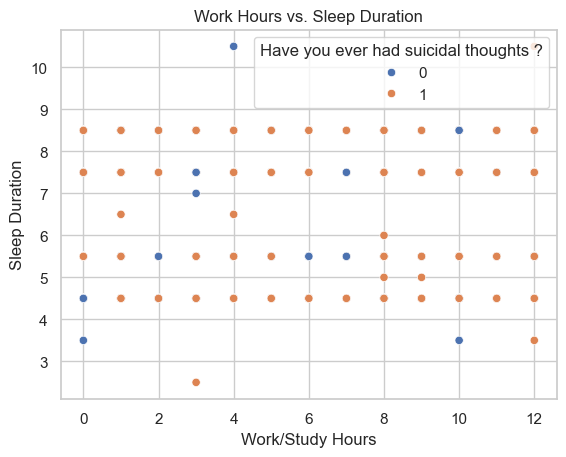

In [107]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.scatterplot(x='Work/Study Hours', y='Sleep Duration',
                hue='Have you ever had suicidal thoughts ?', data=train_data_clean)
plt.title('Work Hours vs. Sleep Duration')
plt.show()

ALGORITHMS

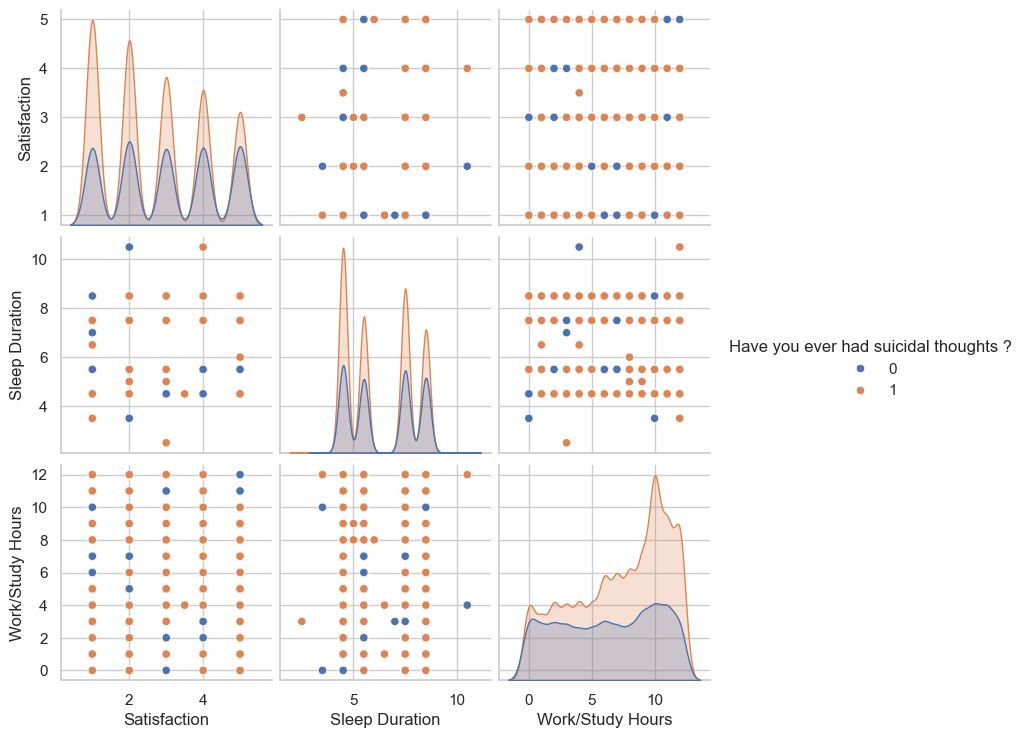

In [108]:
sb.pairplot(train_data_clean[[
    'Satisfaction', 'Sleep Duration', 'Work/Study Hours',
    'Have you ever had suicidal thoughts ?'
]], hue='Have you ever had suicidal thoughts ?')
plt.show()

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

training_data = train_data_clean.copy()

training_data.drop(columns=['id', 'Name'], inplace=True)

categorical_cols = training_data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    training_data[col] = le.fit_transform(training_data[col].astype(str))
    label_encoders[col] = le

X = training_data.drop(columns=['Depression'])
y = training_data['Depression']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
#ACCURACY DE 86

Accuracy: 0.8667253348978194
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      5084
           1       0.87      0.86      0.87      5143

    accuracy                           0.87     10227
   macro avg       0.87      0.87      0.87     10227
weighted avg       0.87      0.87      0.87     10227

